# CNN Assignment

### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Data Import - Importing file paths of images 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
# Printing the count of images in each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


In [4]:
# # Saving the train and test file paths
train_data_path = list(data_dir_train.glob('*/*.jpg'))
test_data_path = list(data_dir_test.glob('*/*.jpg'))

### Create a dataset

In [ ]:
# Train DataFrame

# Class Labels
labels =[]
for i in train_data_path:
    labels.append(i.parts[2])
    
# Dataframe 
ds = pd.DataFrame(train_data_path, columns=["File_path"])
ds["Class"] = labels

# Image as matrix from file path
Image_matrix = []
for i in range(len(ds.File_path)):
    Image_matrix.append(np.asarray(Image.open(ds.File_path[i]).resize([180,180])))

ds["Image_matrix"] = Image_matrix

# Drop the file path column
# ds.drop("File_path", axis=1, inplace=True)

# Label Encoder for classes
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(ds.Class)
# le.classes_
ds["Labels"] = le.transform(ds.Class)

In [ ]:
ds.head()

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Load using keras.preprocessing
# Let's load these images off disk using the helpful <b>image_dataset_from_directory</b> utility.
# Use 80% of the images for training, and 20% for validation.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.
Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

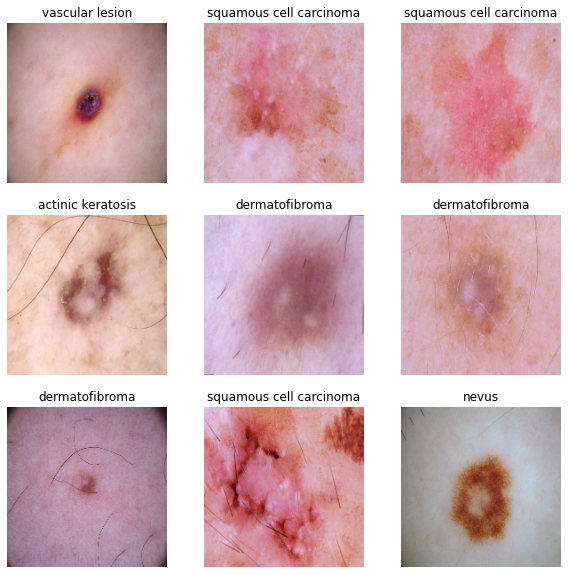

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 1

In [10]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [11]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16588928  
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 16,590,537
Trainable params: 16,590,537
Non-trainable params: 0
____________________________________________

### Train the model

In [13]:
history = model.fit(train_ds,validation_data=val_ds,epochs=2)

Epoch 1/2
281/281 [==============================] - 82s 203ms/step - loss: 12.1139 - accuracy: 0.0970 - val_loss: 12.2816 - val_accuracy: 0.0935
Epoch 2/2
281/281 [==============================] - 57s 201ms/step - loss: 12.1242 - accuracy: 0.0964 - val_loss: 12.2816 - val_accuracy: 0.0935


### Visualizing training results

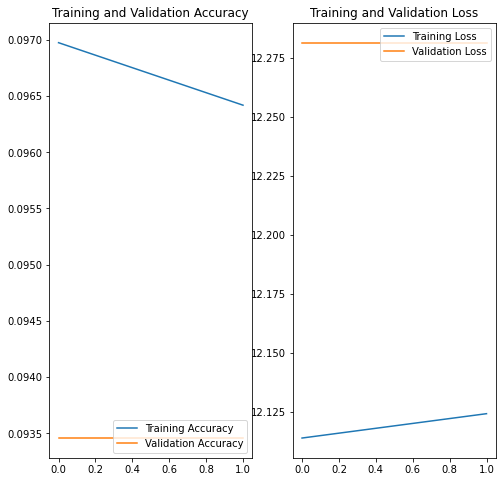

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference
The model overfits

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

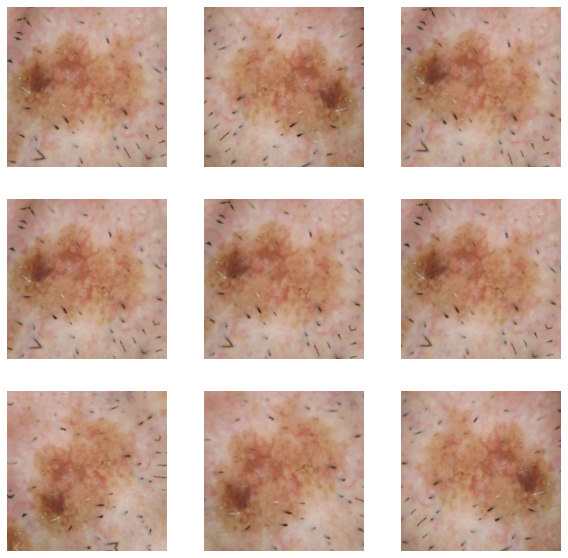

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Model 2

In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(train_ds,validation_data=val_ds,epochs=2)

Epoch 1/2
281/281 [==============================] - 76s 268ms/step - loss: 14.5522 - accuracy: 0.0966 - val_loss: 14.5041 - val_accuracy: 0.1001
Epoch 2/2
281/281 [==============================] - 79s 279ms/step - loss: 14.5586 - accuracy: 0.0968 - val_loss: 14.5041 - val_accuracy: 0.1001


### Visualizing the results

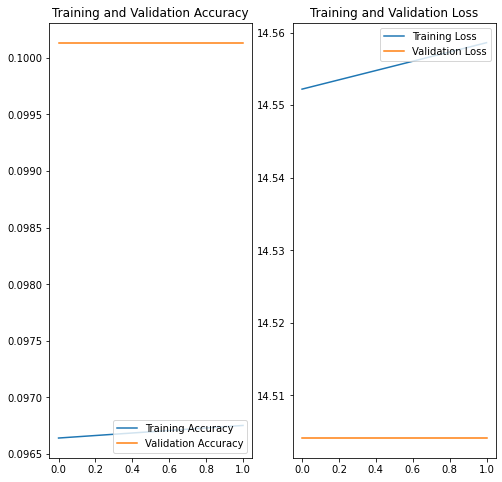

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference
The Model still overfits

In [22]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2235,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2236,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2237,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


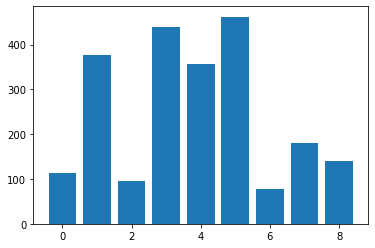

In [24]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
X, y = original_df['Path'], original_df['Label']
y = LabelEncoder().fit_transform(y)

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [25]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9D595A7A30>: 100%|██████████| 500/500 [00:06<00:00, 72.55 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D5A50DE50>:   1%|          | 5/500 [00:00<01:25,  5.77 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F64270460>: 100%|██████████| 500/500 [00:05<00:00, 87.05 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9D595A7A60>:   2%|▏         | 12/500 [00:00<01:06,  7.31 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D558C2AC0>: 100%|██████████| 500/500 [00:06<00:00, 82.54 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9F64B13910>: 100%|██████████| 500/500 [00:32<00:00, 15.59 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D55F926A0>: 100%|██████████| 500/500 [00:27<00:00, 17.97 Samples/s]                    
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F64B136A0>:   3%|▎         | 13/500 [00:00<00:59,  8.22 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F4BC241F0>: 100%|██████████| 500/500 [00:05<00:00, 97.35 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9D5763CFD0>: 100%|██████████| 500/500 [00:12<00:00, 39.08 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9D55F8BF10>:   2%|▏         | 11/500 [00:00<01:10,  6.90 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D55BEC820>: 100%|██████████| 500/500 [00:05<00:00, 86.77 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F64D9C310>:   1%|          | 5/500 [00:00<01:18,  6.28 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D595C5070>: 100%|██████████| 500/500 [00:05<00:00, 88.44 Samples/s]                   


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [31]:
new_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


### Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


## Model 3

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile your model (Choose optimizer and loss function appropriately)

In [36]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

### Train your model

In [37]:
history = model.fit(train_ds,validation_data=val_ds,epochs=3)

Epoch 1/3
394/394 [==============================] - 137s 247ms/step - loss: 13.3992 - accuracy: 0.1062 - val_loss: 13.5128 - val_accuracy: 0.1004
Epoch 2/3
394/394 [==============================] - 90s 226ms/step - loss: 13.4960 - accuracy: 0.1051 - val_loss: 13.5128 - val_accuracy: 0.1004
Epoch 3/3
394/394 [==============================] - 90s 227ms/step - loss: 13.4960 - accuracy: 0.1051 - val_loss: 13.5128 - val_accuracy: 0.1004


### Visualize the model results

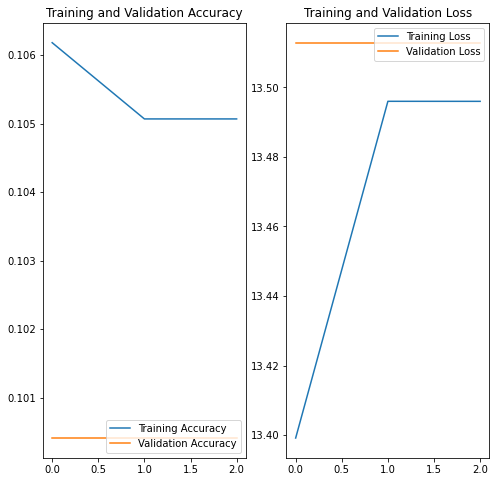

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Final Report
There has been a huge class imbalance that had been affecting the model's performance a lot. Data upsampling has heavily helped the model to fit properly
Train acc : ~90%
Test acc  : ~80%
    
<b>Getting huge amounts of data will improve the model tremendously<b>